[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM-examples.git/main?urlpath=PySDM_examples/Singer/surf_tense_mcmc.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Singer/surf_tens_mcmc.ipynb)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
%env NUMBA_DISABLE_JIT=1

env: NUMBA_DISABLE_JIT=1


In [5]:
from matplotlib import pylab
import numpy as np
from PySDM import Formulae
from PySDM.physics import si, constants as const
from atmos_cloud_sim_uj_utils import show_plot
from PySDM_examples.Singer.aerosol import AerosolBetaCary

In [6]:
from PySDM.physics.surface_tension import compressed_film_ovadnevaite
compressed_film_ovadnevaite.sgm_org = 40.0 * si.mN / si.m
compressed_film_ovadnevaite.delta_min = 0.3 * si.nm

In [7]:
formulae_ovad = Formulae(surface_tension='CompressedFilmOvadnevaite')
label = 'Ovad'

cases = {
    'Beta Caryophyllene': AerosolBetaCary()
}

r_wet = np.logspace(np.log(150 * si.nm), np.log(3000 * si.nm), base=np.e, num=100)
r_dry = 50 * si.nm
v_wet = formulae_ovad.trivia.volume(r_wet)
v_dry = formulae_ovad.trivia.volume(r_dry)
T = 300 * si.K
r_wet_ticks_nm = (300, 500, 700, 1000, 3000)

In [9]:
from importlib import reload
import kappa_mcmc
reload(kappa_mcmc)
from kappa_mcmc import param_transform, get_model, MCMC

params = [0.22, -1.2]
#params = [0.2, -1.5]
stepsize = [0.01,0.01]

ds = np.loadtxt("bcary_kappa.csv",skiprows=1,delimiter=",")
rd = ds[:,0]*1e-9
ovf = np.minimum(ds[:,1], 0.99)
kappa_eff = ds[:,2]

datay = kappa_eff
errory = datay*0.1

v_dry = formulae_ovad.trivia.volume(rd)
r_wet = 300e-9
v_wet = formulae_ovad.trivia.volume(r_wet)
args = [T, v_wet, v_dry, ovf]

n_steps = 10000
param_chain, accept_chain, chi2_chain = MCMC(params, stepsize, args, datay, errory, n_steps)

[34.91070481  1.18265527]


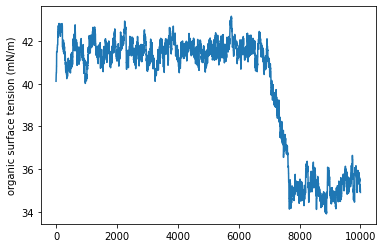

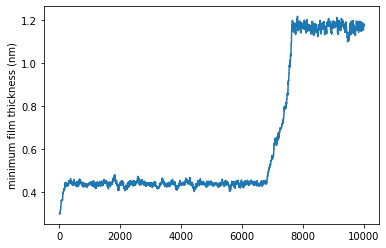

In [10]:
# pylab.plot(param_chain[0,:])
# pylab.show()
# pylab.plot(param_chain[1,:])
# pylab.show()

p = param_transform(param_chain)
print(p[:,-1])
pylab.plot(p[0,:])
pylab.ylabel("organic surface tension (mN/m)")
pylab.show()
pylab.plot(p[1,:])
pylab.ylabel("minimum film thickness (nm)")
pylab.show()

### Surface tension

[40.11423447  0.30119421]
[34.91070481  1.18265527]


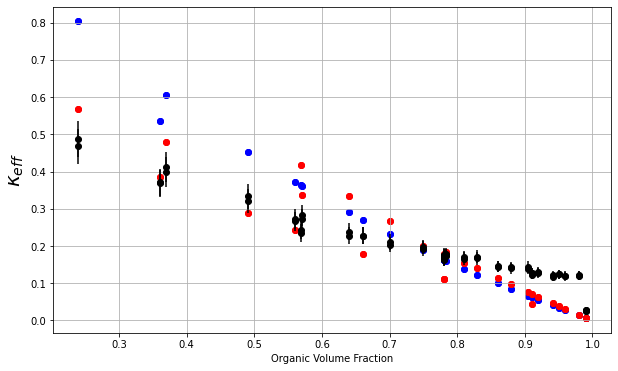

In [11]:
reload(kappa_mcmc)
from kappa_mcmc import *

pylab.figure(figsize=(10,6))

# before
p = param_transform(param_chain[:,0])
print(p)

compressed_film_ovadnevaite.sgm_org = p[0] * si.mN / si.m
compressed_film_ovadnevaite.delta_min = p[1] * si.nm
formulae_1 = Formulae(surface_tension='CompressedFilmOvadnevaite')
c = AerosolBetaCary(ovf)
f_org = c.aerosol_modes_per_cc['f_org']
kappa = c.aerosol_modes_per_cc['kappa']['Ovad']
sig = formulae_1.surface_tension.sigma(T, v_wet, v_dry, f_org)
rd3 = (3 * v_dry) / (4 * np.pi)
rcrit = formulae_1.hygroscopicity.r_cr(kappa, rd3, T, sig)
kap_eff = (2 * rcrit**2) / (3 * rd3 * const.Rv * T * const.rho_w) * const.sgm_w
#pylab.scatter(ovf, kap_eff, label="before", c=rd3**(1/3)*1e9, cmap="Blues", marker="o")
pylab.scatter(ovf, kap_eff, label="before", c="b")

# after
p = param_transform(param_chain[:,-1])
print(p)

compressed_film_ovadnevaite.sgm_org = p[0] * si.mN / si.m
compressed_film_ovadnevaite.delta_min = p[1] * si.nm
formulae_1 = Formulae(surface_tension='CompressedFilmOvadnevaite')
c = AerosolBetaCary(ovf)
f_org = c.aerosol_modes_per_cc['f_org']
kappa = c.aerosol_modes_per_cc['kappa']['Ovad']
sig = formulae_1.surface_tension.sigma(T, v_wet, v_dry, f_org)
rd3 = (3 * v_dry) / (4 * np.pi)
rcrit = formulae_1.hygroscopicity.r_cr(kappa, rd3, T, sig)
kap_eff = (2 * rcrit**2) / (3 * rd3 * const.Rv * T * const.rho_w) * const.sgm_w
#pylab.scatter(ovf, kap_eff, label="before", c=rd3**(1/3)*1e9, cmap="Reds", marker="o")
pylab.scatter(ovf, kap_eff, label="before", c="r")

# data
pylab.errorbar(ovf, kappa_eff, yerr=errory, fmt='ko')

#pylab.colorbar(label="Dry radius (nm)")
pylab.xlabel("Organic Volume Fraction")
pylab.ylabel("$\kappa_{eff}$",fontsize=20)
pylab.rcParams.update({"font.size":15})
pylab.grid()
pylab.show()